<a href="https://colab.research.google.com/github/PaulaMateos/IRWA-2024-G_102_1/blob/main/Project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Text Processing and Exploratory Data Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Python packages
Let's first import all the packages that you will need during this assignment.

In [11]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import json
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Dataset

In [5]:
evaluation = '/content/drive/Shared drives/IRWA/ProjectPart1/inputs/evaluation_gt.csv'
farmers_tweets = '/content/drive/Shared drives/IRWA/ProjectPart1/inputs/farmers-protest-tweets.json'
tweet_document_ids = '/content/drive/Shared drives/IRWA/ProjectPart1/inputs/tweet_document_ids_map.csv'

In [6]:
# Step 1: Load and Map Data
## Load JSON Data
with open(farmers_tweets, 'r') as f:
    tweet_data = [json.loads(line) for line in f]  # Assuming each line is a separate JSON object

# Convert JSON data to DataFrame
df_tweets = pd.DataFrame(tweet_data)

# Load the tweet-document ID map
doc_id_map = pd.read_csv(tweet_document_ids)

# Merge data to include `docId` in the tweet DataFrame
df_tweets = df_tweets.merge(doc_id_map, how='inner', left_on='id', right_on='id')

# Load Evaluation Data
evaluation_data = pd.read_csv(evaluation)

## Step 1: Text Processing
- Remove Stop Words
- Punctuation
- Tokenize

### Stem

In [7]:
# Function to preprocess each tweet
def preprocess_tweet(tweet_content):
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()

    # Lowercase the tweet
    tweet_content = tweet_content.lower()
    tokenized_tweet = tweet_content.split()

    # Remove stop words and punctuation, apply stemming
    processed_tokens = [ps.stem(word) for word in tokenized_tweet if word.isalpha() and word not in stop_words]

    # Return the processed text as a string
    return ' '.join(processed_tokens)

# Apply preprocessing to the tweets
# for tweet in df_tweets:
#     tweet['processed_content'] = preprocess_tweet(tweet['content'])
for index, tweet in df_tweets.iterrows():
    df_tweets.at[index, 'processed_content'] = preprocess_tweet(tweet['content'])

In [8]:
print(df_tweets.head(1)["content"])
print(df_tweets.head(1)["processed_content"])

0    The world progresses while the Indian police a...
Name: content, dtype: object
0    world progress indian polic govt still tri tak...
Name: processed_content, dtype: object


## Step 2: Exploratory Data Analysis

### Word Count Distribution

Average sentence length: 8.006359825724257


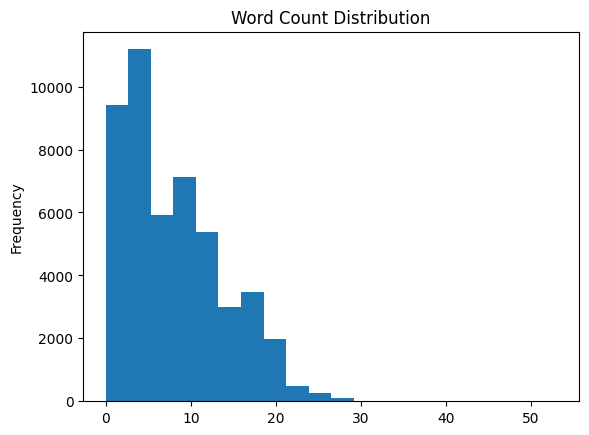

In [12]:
# Word count distribution based on preprocessed tweets
df_tweets['word_count'] = df_tweets['processed_content'].apply(lambda x: len(x.split()))

# Average sentence length
average_sentence_length = df_tweets['word_count'].mean()
print(f'Average sentence length: {average_sentence_length}')

# Word count distribution
df_tweets['word_count'].plot(kind='hist', bins=20, title='Word Count Distribution')
plt.show()


### Vocabulary Size

In [13]:
# Get all words from the processed content
all_words = ' '.join(df_tweets['processed_content']).split()

# Vocabulary size (unique words)
vocabulary_size = len(set(all_words))
print(f'Vocabulary size: {vocabulary_size}')


Vocabulary size: 15637


### Top Retweeted Tweets

In [15]:
# Top 5 most retweeted tweets
most_retweeted = df_tweets[['content', 'retweetCount']].sort_values(by='retweetCount', ascending=False).head(5)
print("Most retweeted tweets:")
display(most_retweeted)


Most retweeted tweets:


,content,retweetCount
3203,There's a #FarmersProtest happening in Germany...,6164
38410,"disha ravi, a 21-year-old climate activist, ha...",4673
38012,Disha Ravi broke down in court room and told j...,3742
46206,Farmers are so sweet. Y’all have to see this @...,3332
27071,india is targeting young women to silence diss...,3230


### Word Cloud

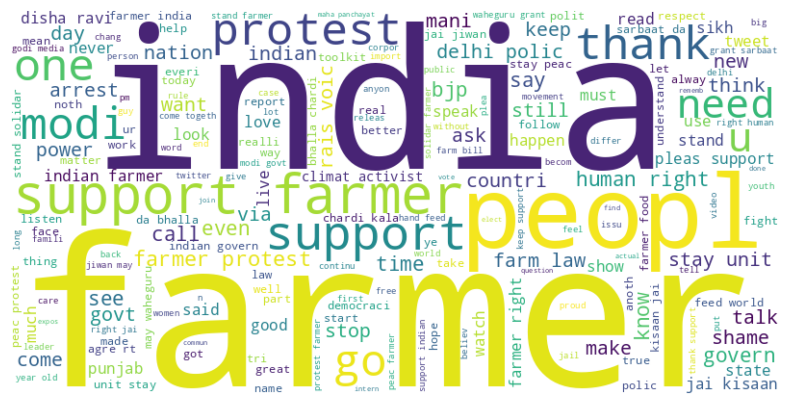

In [17]:
from wordcloud import WordCloud

# Generate a word cloud from the processed content
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Entity Recognition

In [18]:
import spacy

# Load the spaCy model for NER
nlp = spacy.load('en_core_web_sm')

# Apply NER to a few sample tweets
for tweet in df_tweets['content'].head(5):
    doc = nlp(tweet)
    print(f"\nTweet: {tweet}")
    for ent in doc.ents:
        print(f"Entity: {ent.text}, Label: {ent.label_}")



Tweet: The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF
Entity: Indian, Label: NORP
Entity: Govt, Label: ORG
Entity: India, Label: GPE
Entity: FarmersProtest, Label: MONEY

Tweet: #FarmersProtest 
#ModiIgnoringFarmersDeaths 
#ModiDontSellFarmers 
@Kisanektamorcha 
Farmers constantly distroying crops throughout India. 
Really, it's hearts breaking...we care about our crops like our children. And govt. agriculture minister is laughing on us🚜🌾WE WILL WIN💪 https://t.co/kLspngG9xE
Entity: FarmersProtest, Label: ORG
Entity: #ModiIgnoringFarmersDeaths, Label: MONEY
Entity: Farmers, Label: ORG
Entity: India, Label: GPE
Entity: 🚜, Label: GPE
Entity: https://t.co/kLspngG9xE, Label: GPE

Tweet: @ReallySwara @rohini_sgh watch full video here https://t.co/wBPNdJdB0n
#farmersprotest #NoFarmersNo

In [20]:
!pip install squarify

### Tree map of the top hastags

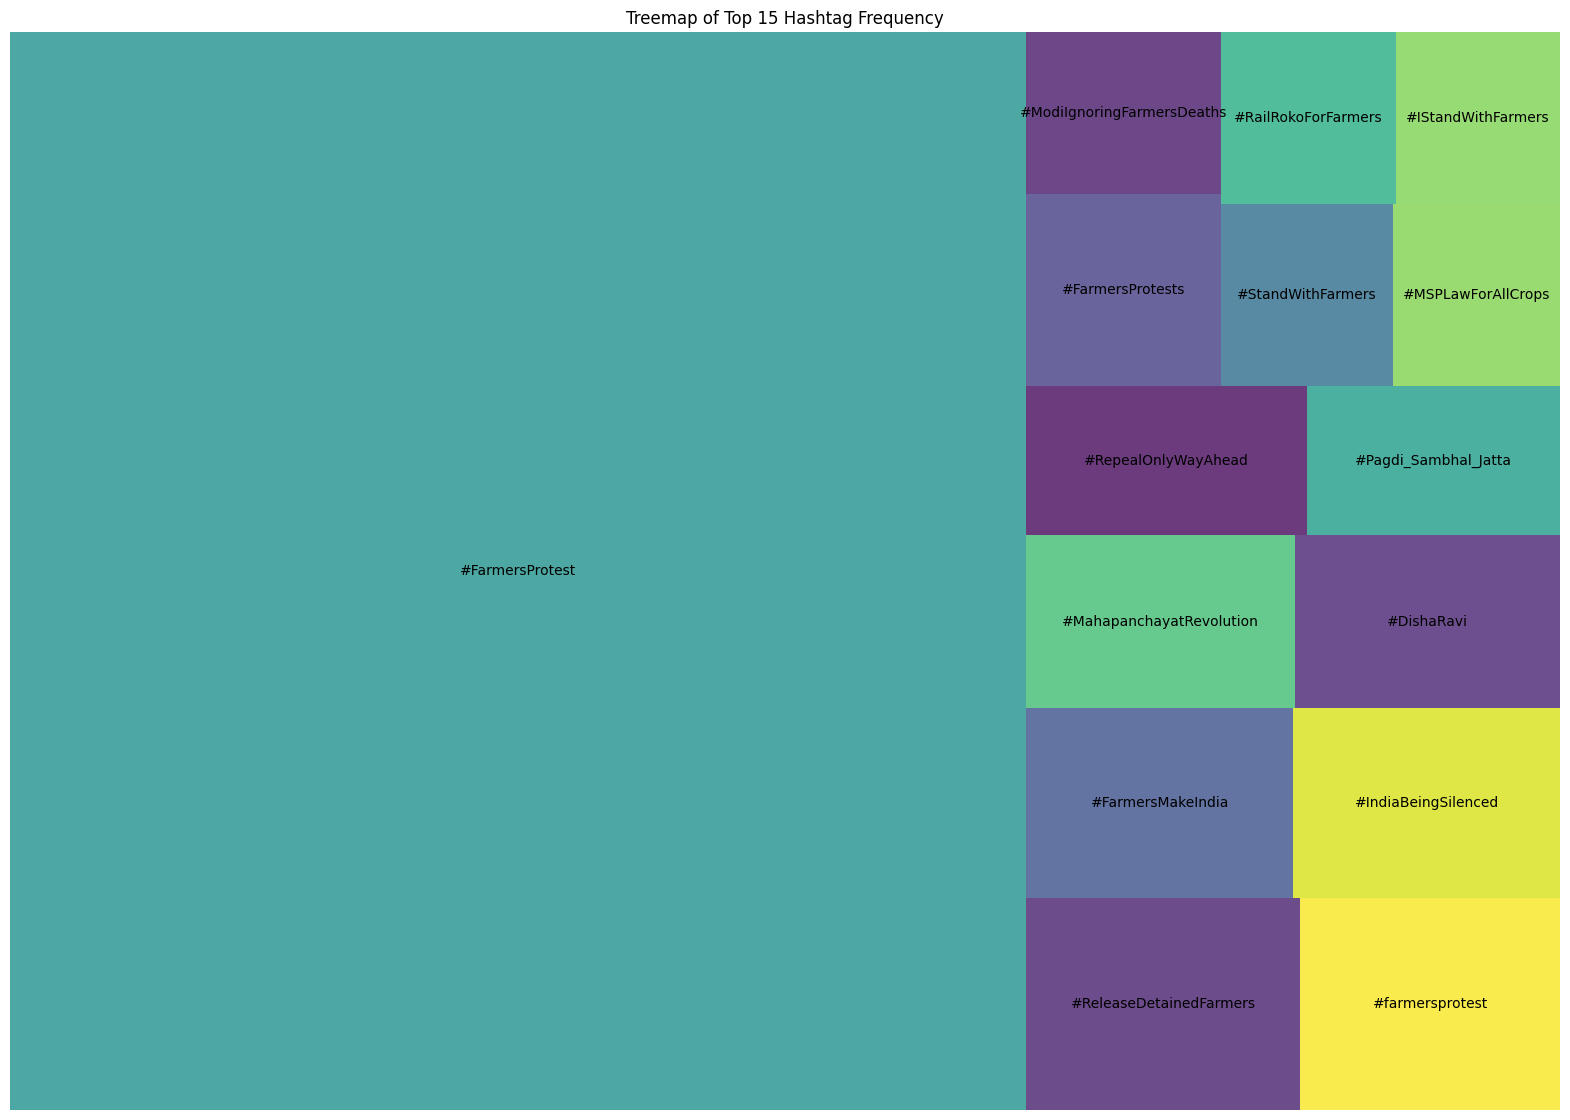

In [25]:
from collections import Counter
import squarify
import re
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Extract hashtags from the original tweets (content)
df_tweets['hashtags'] = df_tweets['content'].apply(lambda x: re.findall(r'#\w+', x))

# Flatten the list of hashtags
all_hashtags = [hashtag for hashtags in df_tweets['hashtags'] for hashtag in hashtags]

# Get the frequency distribution of hashtags
hashtag_counts = Counter(all_hashtags)

# Get the top 15 hashtags
top_hashtags = hashtag_counts.most_common(15)

# Create a DataFrame for the treemap
hashtag_df = pd.DataFrame(top_hashtags, columns=['hashtag', 'count'])

# Plot the treemap (with the top 15 hashtags)
plt.figure(figsize=(20, 14))
squarify.plot(sizes=hashtag_df['count'], label=hashtag_df['hashtag'], alpha=.8)
plt.title('Treemap of Top 15 Hashtag Frequency')
plt.axis('off')
plt.show()



### Time visualitzation of the publicated tweets

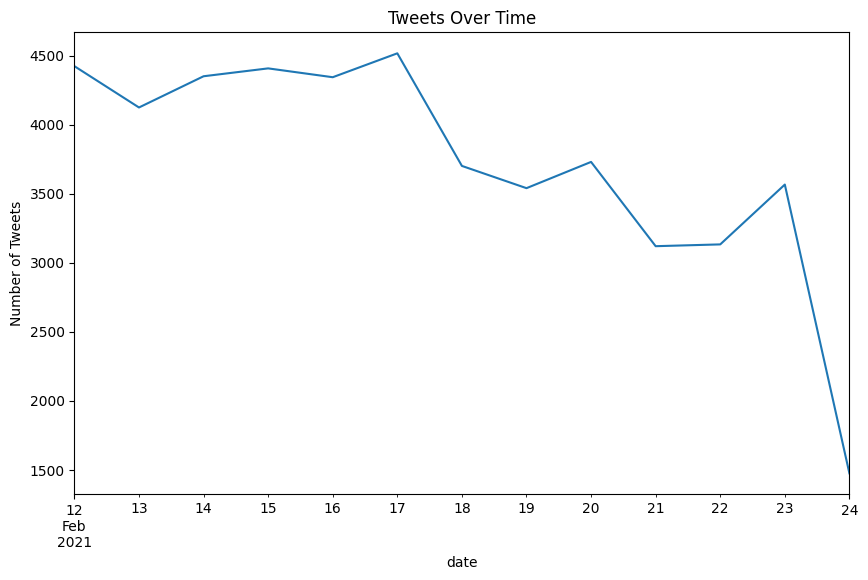

In [23]:
# Convert the 'date' column to datetime
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

# Create a time series plot for tweet frequency over time
df_tweets.set_index('date', inplace=True)
df_tweets['tweet_count'] = 1

# Resample the data by day or hour and plot
daily_tweets = df_tweets['tweet_count'].resample('D').sum()
daily_tweets.plot(figsize=(10,6), title='Tweets Over Time')
plt.ylabel('Number of Tweets')
plt.show()


### Top users by tweet count

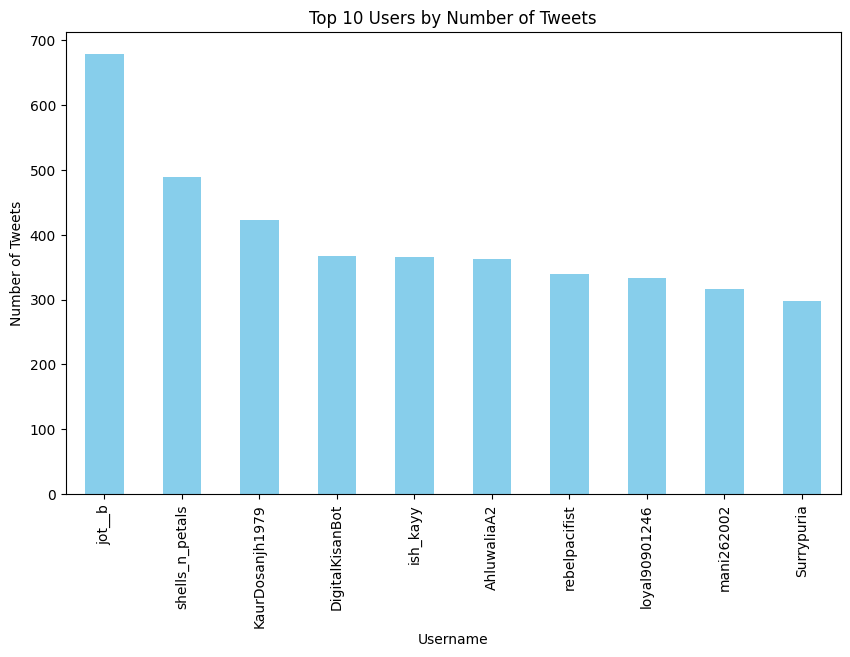

In [27]:
# Find the top 10 users by tweet count (based on 'username' field)
top_users = df_tweets['user'].apply(lambda x: x['username']).value_counts().head(10)

# Plot the top users by username
top_users.plot(kind='bar', figsize=(10, 6), color='skyblue', title='Top 10 Users by Number of Tweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Username')
plt.show()



### Retweets vs likes correlation

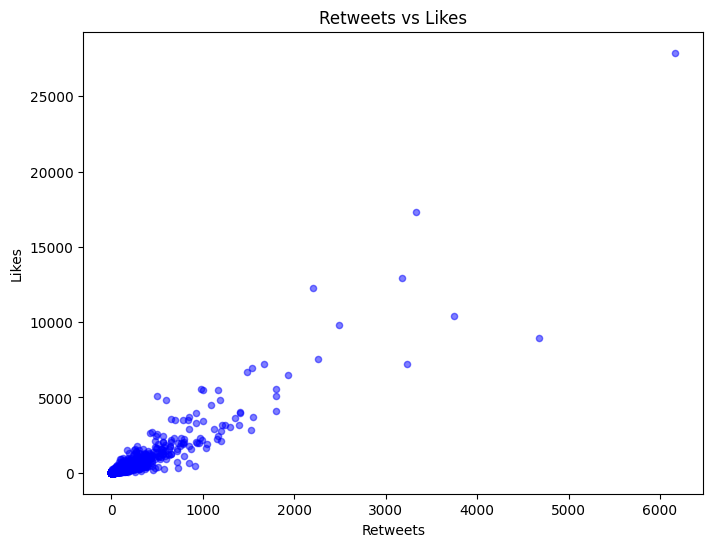

In [28]:
# Scatter plot for retweets vs likes
df_tweets.plot(kind='scatter', x='retweetCount', y='likeCount', alpha=0.5, color='blue', figsize=(8,6), title='Retweets vs Likes')
plt.xlabel('Retweets')
plt.ylabel('Likes')
plt.show()


### Heatmap

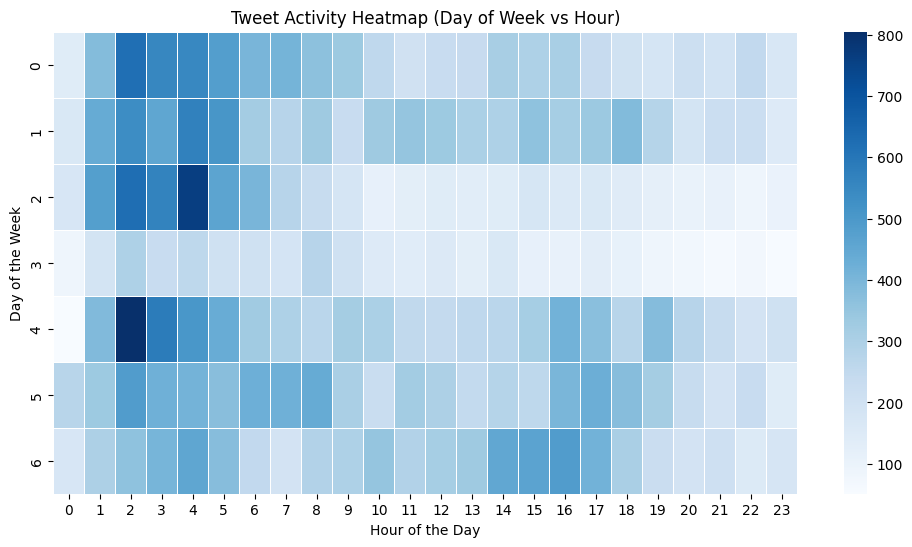

In [29]:
# Create new columns for hour and day of the week
df_tweets['hour'] = df_tweets.index.hour
df_tweets['day_of_week'] = df_tweets.index.dayofweek

# Pivot table to create a matrix for the heatmap
heatmap_data = df_tweets.pivot_table(index='day_of_week', columns='hour', values='tweet_count', aggfunc='sum')

# Plot heatmap
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap='Blues', linewidths=.5)
plt.title('Tweet Activity Heatmap (Day of Week vs Hour)')
plt.ylabel('Day of the Week')
plt.xlabel('Hour of the Day')
plt.show()
